### Packages

In [11]:
cd '/h/ama/workspace/ama-at-vector/best-mix'

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import pickle

from mixup import mixup_graph

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [14]:
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()

### Model, Data, Saliency

In [15]:
''' Model '''
import models
# import torchvision.models as models
from load_data import load_data_subset
from collections import OrderedDict


resnet = models.__dict__['preactresnet18'](200, False, 2).cuda()

# checkpoint = torch.load('/group-volume/Multimodal-Learning/ssl/vse_files/runs/fast_autoaugment/models/cifar10_preact_ckpt/vanilla.pth.tar')
checkpoint = torch.load('/scratch/hdd001/home/ama/mixup/2022-07-23/20220723287227464/7937126/custom_ckpt.pth')

od = OrderedDict()
for key in checkpoint['state_dict'].keys():
    od[key[7:]] = checkpoint['state_dict'][key]
resnet.load_state_dict(od)



# stride = 2
# args.mean = torch.tensor([0.5] * 3, dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
# args.std = torch.tensor([0.5] * 3, dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
# args.labels_per_class = 500




# resnet.load_state_dict(checkpoint['state_dict'])
# mean = torch.tensor([x / 255 for x in [125.3, 123.0, 113.9]],dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
# std = torch.tensor([x / 255 for x in [63.0, 62.1, 66.7]], dtype=torch.float32).reshape(1, 3, 1, 1).cuda()
labels_per_class = 500
mean = torch.tensor([0.5,0.5,0.5])
std = torch.tensor([0.5,0.5,0.5])
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

criterion = nn.CrossEntropyLoss()


batch_size = 100
workers=2
dataset='tiny-imagenet-200'
# data_dir='/group-volume/Multimodal-Learning/ssl/vse_files/runs/fast_autoaugment/data'
data_dir='/h/ama/workspace/ama-at-vector/best-mix/data/tiny-imagenet-200'
valid_labels_per_class=0
mixup_alpha=0
train_loader, valid_loader, _, test_loader, num_classes = load_data_subset(
        batch_size,
        workers,
        dataset,
        data_dir,
        labels_per_class=labels_per_class,
        valid_labels_per_class=valid_labels_per_class,
        mixup_alpha=mixup_alpha)

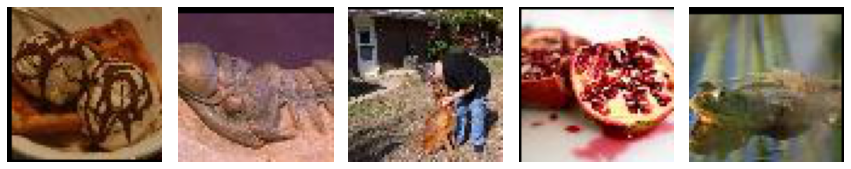

In [16]:
''' Data '''

sample_num=5
for x,y in train_loader:
    input_sp,targets = x[:sample_num,:],y[:sample_num]
    break
    
print_fig((input_sp * std_torch + mean_torch)[:sample_num])

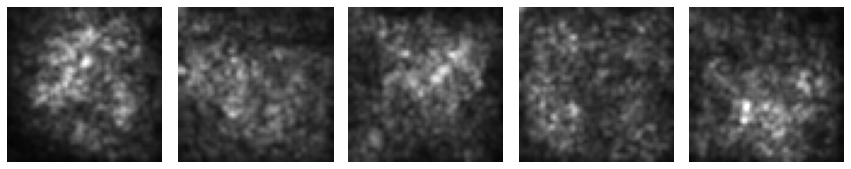

In [17]:
''' Saliency '''
resnet.cpu()
resnet.train()
input_var = input_sp[:sample_num].clone().detach().requires_grad_(True)
output = resnet(input_var)
loss = criterion(output, targets[:sample_num])
loss.backward()

blurr = torchvision.transforms.GaussianBlur(3, sigma=(1.0, 1.0))
grad = input_var.grad.detach().abs().mean(dim=1).squeeze()
blurred_grad = blurr(grad)
normalized_grad = blurred_grad/blurred_grad.sum(dim=[1,2],keepdim=True).detach()

# grad_copy = grad.clone()
# grad_copy = blurr(grad_copy).squeeze()
# grad_min = grad_copy.amin(dim=[1,2],keepdim=True).detach()
# grad_copy -= grad_min
# grad_max = grad_copy.amax(dim=[1,2],keepdim=True).detach()
# grad_copy /=grad_max

# # grad_copy = blurr(grad_copy).squeeze()

# print_fig(grad/grad.amax(dim=[1,2],keepdim=True).detach())
print_fig(normalized_grad*1000)

# T = 0.0001
# flatten_grad = torch.flatten(grad, start_dim=1, end_dim=- 1)
# softmax_grad = torch.nn.Softmax(dim=1)(flatten_grad/T)
# unflatten_grad = torch.nn.Unflatten(1,(32,32))(softmax_grad)

# print_fig(grad)
# print_fig(normalized_grad)


### Ours

0.0
tensor([0.3262, 0.3262, 0.3262, 0.4226, 0.3262], device='cuda:0')


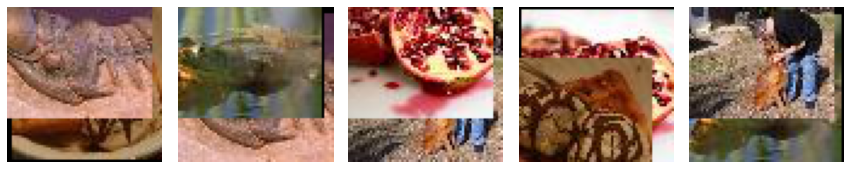

0.1
tensor([0.1417, 0.1877, 0.1324, 0.2156, 0.1626], device='cuda:0')


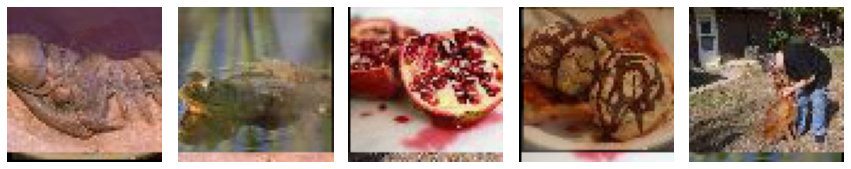

0.2
tensor([0.3631, 0.4203, 0.3478, 0.4404, 0.3906], device='cuda:0')


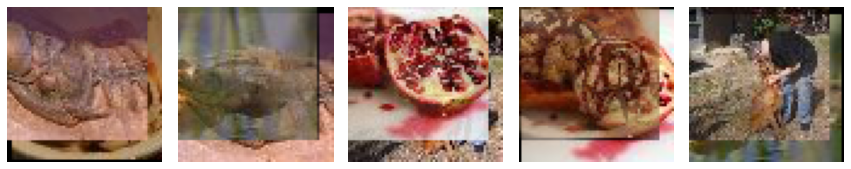

0.30000000000000004
tensor([0.4130, 0.4778, 0.3820, 0.5095, 0.4355], device='cuda:0')


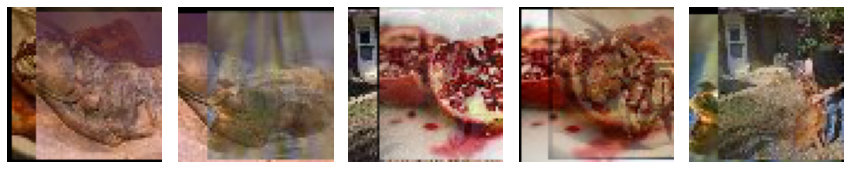

0.4
tensor([0.4529, 0.8140, 0.4293, 0.7966, 0.5003], device='cuda:0')


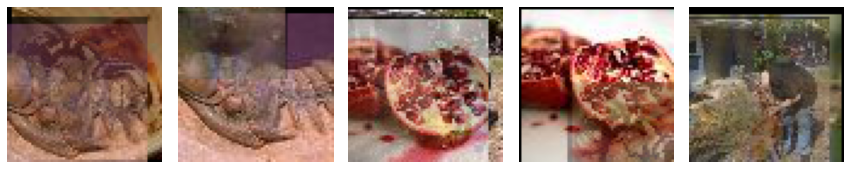

0.5
tensor([0.7326, 0.8017, 0.7642, 0.8828, 0.8066], device='cuda:0')


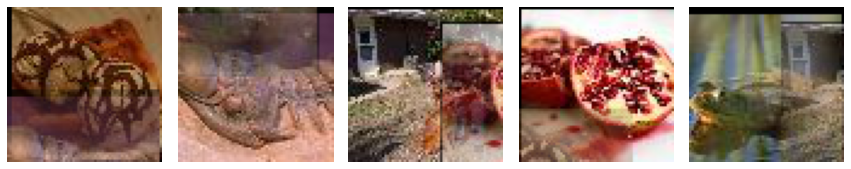

0.6000000000000001
tensor([0.8577, 0.9778, 0.8138, 0.9686, 0.9216], device='cuda:0')


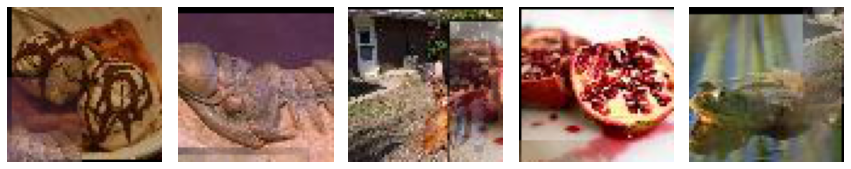

0.7000000000000001
tensor([0.9790, 0.9923, 0.9782, 0.9938, 0.9841], device='cuda:0')


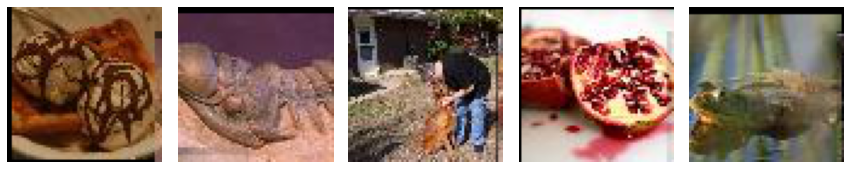

0.8
tensor([0.9899, 0.9974, 0.9944, 0.9987, 0.9960], device='cuda:0')


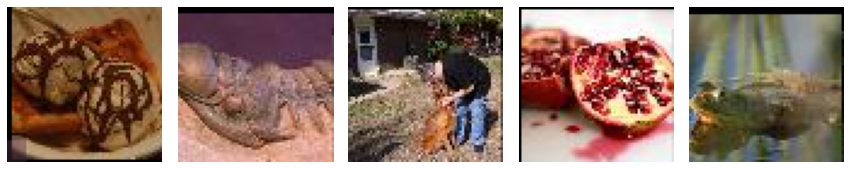

0.9
tensor([0.9967, 0.9985, 0.9966, 0.9994, 0.9975], device='cuda:0')


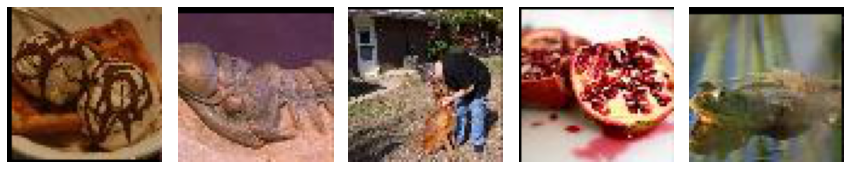

1.0
tensor([1., 1., 1., 1., 1.], device='cuda:0')


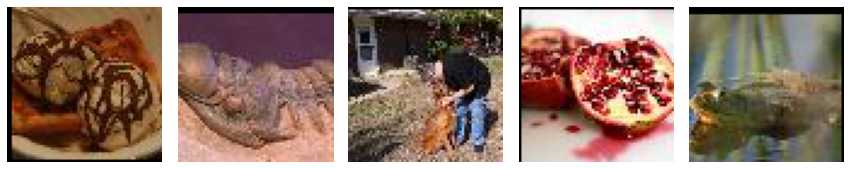

In [21]:
from utils_mixup import gradmix_v2_improved_v4_1

rand_pos = 0.001

for _alpha in np.linspace(0,1,11):
    print(_alpha)
    _sigma = 3.0
#     _alpha = 0.7
    blurr = torchvision.transforms.GaussianBlur(11, sigma=(_sigma, _sigma))

    grad = blurr(input_var.grad.detach().abs().mean(dim=1)).squeeze()

    mixed_x, mixed_y, mixed_lam = gradmix_v2_improved_v4_1(input_sp.cuda(), targets.cuda(), grad.unsqueeze(1).cuda(), alpha = _alpha, normalization = 'standard', debug=True, rand_pos = rand_pos)
    print(mixed_lam[0])
    print_fig(mixed_x.cpu() * std_torch + mean_torch)